<h1><center>Data Science Research Methods</center></h1>
<h2><center>PAMAP2 Dataset Report</center></h2>

# 1. Introduction
<p>PAMAP2 data set is a collection of 18 different physical activities; like walking, cycling, playing soccer among others  performed by 9 subjects. Each of these subjects were wearing 3 inertial measurement units (IMUs) along with a heart rate monitor. The data for each subject is stored separately in text files. Each row represents an enrty and in total there are 54 columns. However, orientation columns are not valid in this collection so we will drop it in the data cleaning step. The goal of the analysis is to extract some actionable insights from the data which can help in further development of some software/harware to measure the amount and type of physical activity performed by an indivisual. The rest of the report is structured in the following fashion:</p>
<ul>
    <li>Data Preparation: reading and collating data from all text files</li>
    <li>Data Cleaning: performing sanity checks and treating erroneous data</li>
    <li>Exploratory Data Analysis: analysing data for any underlying trens and relationships between variables</li>
    <li>Hypothesis Testing: conducting statistical tests to confirm the observed relationships</li>
    <li>Model Development: developing a suitable model which builds upon the previous analyses</li>  
</ul>

# 2. Data Preparation

In [193]:
# Importing required libraries
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import os
# may nee to install PyPDF2 before using
# pip install PyPDF2
import PyPDF2
import re
import seaborn as sns
from statsmodels.stats.weightstats import ztest as ztest
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

<p>To read data from 9 different text files firstly a list of all the file names are required. Below code is reading the text file names located in the "Protocol" folder.</p>

In [2]:
# Reading data from directory
files = os.listdir(".\Protocol")
print(files)

['subject101.dat', 'subject102.dat', 'subject103.dat', 'subject104.dat', 'subject105.dat', 'subject106.dat', 'subject107.dat', 'subject108.dat', 'subject109.dat']


In [3]:
# creating columns names
columnNames = ["timeStamp", "activityID", "heartRate"]

for imu in ["hand", "chest", "ankle"]:
    for col in ["Temp", "Acc16_1", "Acc16_2", "Acc16_3", "Acc6_1", "Acc6_2", "Acc6_3", "Gyr_1", "Gyr_2", "Gyr_3",
                "Magn_1", "Magn_2", "Magn_3", "Orientation_1", "Orientation_2", "Orientation_3", "Orientation_4"]:
        columnNames.append(imu + col)

print(columnNames)

['timeStamp', 'activityID', 'heartRate', 'handTemp', 'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyr_1', 'handGyr_2', 'handGyr_3', 'handMagn_1', 'handMagn_2', 'handMagn_3', 'handOrientation_1', 'handOrientation_2', 'handOrientation_3', 'handOrientation_4', 'chestTemp', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 'chestGyr_1', 'chestGyr_2', 'chestGyr_3', 'chestMagn_1', 'chestMagn_2', 'chestMagn_3', 'chestOrientation_1', 'chestOrientation_2', 'chestOrientation_3', 'chestOrientation_4', 'ankleTemp', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyr_1', 'ankleGyr_2', 'ankleGyr_3', 'ankleMagn_1', 'ankleMagn_2', 'ankleMagn_3', 'ankleOrientation_1', 'ankleOrientation_2', 'ankleOrientation_3', 'ankleOrientation_4']


The activity names will also be required to map to the activityIDs for analysis. Below code chunk creates a dictionary of activities with IDs as keys and activity names as the values.

In [4]:
# creating a pdf file object
pdfFileObj = open('PerformedActivitiesSummary.pdf', 'rb')

# creating a pdf reader object
PdfReader = PyPDF2.PdfReader(pdfFileObj)

# creating a page object
pageObj = PdfReader.pages[0]

# extracting text from page
activityList1 = re.findall(r'[0-9]+ – [aA-z]+ ?[a-z]+', pageObj.extract_text())

# creating a dictionary of
activityIDList = {re.findall(r'[0-9]+', activity)[0]: re.findall(r'[aA-z]+ ?[a-z]+', activity)[0].replace(" ", "_") for
                  activity in activityList1}
activityIDList["0"] = "transient"
print(activityIDList)
# closing the pdf file object
pdfFileObj.close()

{'1': 'lying', '2': 'sitting', '3': 'standing', '4': 'walking', '5': 'running', '6': 'cycling', '7': 'Nordic_walking', '9': 'watching', '10': 'computer_work', '11': 'car_driving', '12': 'ascending_stairs', '13': 'descending_stairs', '16': 'vacuum_cleaning', '17': 'ironing', '18': 'folding_laundry', '19': 'house_cleaning', '20': 'playing_soccer', '24': 'rope_jumping', '0': 'transient'}


<p>To read and collate all the text files into one pandas data frame a function is created which takes the directory path of the text files and returns the collated data frame with all the columns from the text files.</p>

In [5]:
# Function to read data from the text files

def read_files(file_path):
    collatedData = pd.DataFrame()
    fileList = os.listdir(file_path)
    for txtFile in fileList:
        protocolDf = pd.read_csv(file_path + "/" + txtFile, sep="\s+", header=None, names=columnNames)
        protocolDf["subjectID"] = int(re.findall(r'[0-9]+', txtFile)[0])
        collatedData = pd.concat([collatedData, protocolDf], ignore_index=True)
    collatedData.reset_index(inplace=True, drop=True)
    return collatedData

In [6]:
# Reading and collating data into one pandas dataframe

file_path = "./Protocol"
collatedData = read_files(file_path)

In [7]:
collatedData.head()

,timeStamp,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyr_2,ankleGyr_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,ankleOrientation_1,ankleOrientation_2,ankleOrientation_3,ankleOrientation_4,subjectID
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


 <p>From the first look at the data it can be observed that there are some NaN and other undesired data  which can issues further down the analysis. The following section focuses on cleaning data to make it suitable for further analysis.</p>

# 3. Data Cleaning

<p>This step will ensure that the data is ready for further analysis. As mentioned in the "readme.pdf" file, which describes the dataset in detail, that orientation data is invalid in this data collection, therefore orientation columns can be deleted from the dataset altogether. Furthermore, as we observed earlier that there are some rows which contain transient movement information and are labeled as 0. These rows can also be dropped as we only need the actual activity data. Moreover, as mentioned in the "PerformedActivitiesSummary.pdf" document there is some missing data due to two main reasons:
<ol><li>Due to the use of wireless sensors.</li><li>Problems with hardware setup</li></ol>As this data is a timeseries we can impute the missing values using linear interpolation. But we should only consider data from one subject while interpolating. Also we sould first interpolate the data and then remove any transient state information for better results.</p>

In [11]:
# Data cleaning function
def dataCleaner(dirtyData):
    remCols = columnNames[16:20]+columnNames[33:37]+columnNames[50:54]
    
    # remove orientation columns
    dirtyData = dirtyData.drop(remCols, axis = 1)
    
    # Converting data to numeric
    dirtyData = dirtyData.apply(pd.to_numeric, errors = 'coerce')
    
    # Interpolating data
    for ID in collatedData['subjectID'].unique():
        dirtyData[dirtyData['subjectID']==ID] = dirtyData[dirtyData['subjectID']==ID].interpolate() 
    
    # Removing Transient state data
    dirtyData = dirtyData[dirtyData['activityID'] != 0]
    dirtyData.reset_index(inplace=True, drop=True)
    return dirtyData


### 3.1 Changes made to dataset
<p>Following changes were made, in the described order, to the data to render it useful for further steps:</p>
<ol>
    <li>Removed orientation columns as they are invalid for these measurements.</li>
    <li>Converted all the columns to numeric data in case any data column was not numeric.</li>
    <li>Interpolated the timeseries data using in-built pandas interpolate() function. Please note that the interpolation has been done separately for each subject ID so as to avoid any faulty interpolation. 
</ol>

In [12]:
cleanData = dataCleaner(collatedData)

In [13]:
cleanData.head()

,timeStamp,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyr_1,ankleGyr_2,ankleGyr_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,subjectID
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101


In [19]:
# Checking if any Nan values remaining in the dataset
cleanData.isna().sum()

timeStamp       0
activityID      0
heartRate       0
handTemp        0
handAcc16_1     0
handAcc16_2     0
handAcc16_3     0
handAcc6_1      0
handAcc6_2      0
handAcc6_3      0
handGyr_1       0
handGyr_2       0
handGyr_3       0
handMagn_1      0
handMagn_2      0
handMagn_3      0
chestTemp       0
chestAcc16_1    0
chestAcc16_2    0
chestAcc16_3    0
chestAcc6_1     0
chestAcc6_2     0
chestAcc6_3     0
chestGyr_1      0
chestGyr_2      0
chestGyr_3      0
chestMagn_1     0
chestMagn_2     0
chestMagn_3     0
ankleTemp       0
ankleAcc16_1    0
ankleAcc16_2    0
ankleAcc16_3    0
ankleAcc6_1     0
ankleAcc6_2     0
ankleAcc6_3     0
ankleGyr_1      0
ankleGyr_2      0
ankleGyr_3      0
ankleMagn_1     0
ankleMagn_2     0
ankleMagn_3     0
subjectID       0
dtype: int64

<p>It can be seen that all the NaN values are now treated and the data is ready for further analysis.</p>

# 4. Exploratory Data Analysis

<p>Before starting any analysis the data should be split into training and test datasets so as to prevent the model from overfitting and provide a test sample for analysing the predicting power of the models.</p>

## 4.1 Splitting Data
<p>Before splitting the data into training and test samples it is important to know which sampling methodology is suitable for the given dataset. It can be observed from the below piechart that the data is not proportionately divided among the different activity groups hence random sampling can create even more skewed distributions in the training/testing samples. To avoid this from happening we can use stratified sampling approach which ensures the proportionate distribution.</p>

In [158]:
# Defining plotting function
def nicePlots(plottype,data,xaxis,yaxis=None,xlabel = None,ylabel = None,title = None):
    if xlabel == None:
        xlabel = xaxis
    if ylabel == None:
        ylabel = yaxis
    plt.figure(figsize=(20,5))
    sns.set_style("whitegrid") 
    sns.set(font_scale = 1.5)
    if plottype == "scatter":
        sns.scatterplot(data = data, x = xaxis, y = yaxis)
    elif plottype == "boxplot":
        plt.figure(figsize=(15,8))
        sns.boxplot(data = data, x=xaxis, y=yaxis,orient = "h")
    elif plottype == "barplot":
        sns.barplot(x=xaxis, y=yaxis, data=data)
    elif plottype == "piechart":
        data[xaxis].value_counts().plot(kind="pie", label=xaxis, title=title)

    if plottype != "piechart":
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
    return plt
        


<module 'matplotlib.pyplot' from 'C:\\Users\\kshit\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

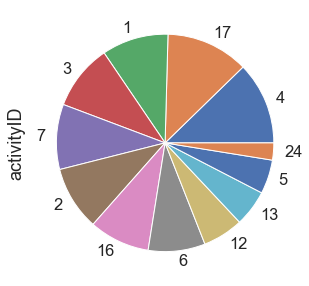

In [112]:
nicePlots("piechart",cleanData, 'activityID')

In [113]:
# Function to create stratified samples
def stratSample(df_input, stratify_colname, frac_train, random_state):
    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [114]:
dataTrain, dataTest = stratSample(cleanData, "activityID", 0.67, 1)
dataTrain.head()

,timeStamp,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyr_1,ankleGyr_2,ankleGyr_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,subjectID
0,2038.56,13,158.0,33.2500,-7.35968,2.28006,5.194930,-7.16176,2.71678,5.778740,...,8.72863,-2.997710,-3.66064,0.043535,-0.032815,-0.032849,-36.96500,19.15340,28.06230,106
1,384.34,2,85.0,32.1875,1.88464,8.23650,4.774480,1.92184,8.31384,4.987040,...,-1.22488,0.955483,-9.64431,-0.007928,-0.045377,-0.013409,-11.53370,33.69820,72.68790,101
2,726.66,3,71.0,33.2500,-9.31532,2.44787,1.046920,-9.23365,2.50123,1.522910,...,9.08857,0.344542,-4.03655,-0.036205,-0.078317,0.001963,4.24416,-6.37674,13.48630,107
3,2549.15,4,95.0,31.5625,-13.43790,4.44816,0.478085,-13.19810,4.91535,0.811943,...,9.18422,-3.359120,-2.45108,0.568106,-0.195165,-0.648215,-55.83180,32.10370,-3.36399,106
4,3016.27,6,116.0,30.6875,-4.69561,3.34432,7.732920,-5.09554,3.98959,10.092700,...,16.81000,-3.298580,-3.80854,-0.005420,-0.015093,0.792738,-38.39830,-18.15970,11.64800,108


In [115]:
print("Taining sample size:",dataTrain.shape)
print("Testing sample size:",dataTest.shape)

Taining sample size: (1301724, 43)
Testing sample size: (641148, 43)


<p>The data has been split into two parts namely, training and test datasets. As there is no dearth of data the it was decided to split the data in 2:1 proportion respectively. In other words 67% data was allocated to training data and rest for testing sample. This is a commonly used proportion used by data scientists.</p>

<module 'matplotlib.pyplot' from 'C:\\Users\\kshit\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

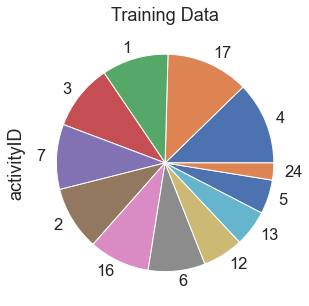

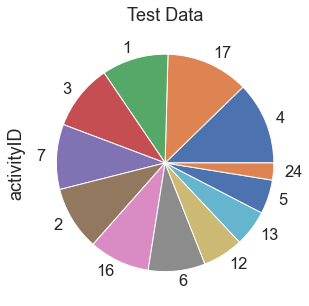

In [116]:
# Checking the samples for proportions of activity IDs
nicePlots("piechart",dataTrain, 'activityID',title='Training Data')
nicePlots("piechart",dataTest, 'activityID',title='Test Data')

# 4.2 Data Visualisation
<p>Now that we have our training and testing samples separated we can proceed with visualising the data to find underlying patterns and subsequently suggest a hypothesis to test based on the observed patterns. Firstly, let us summarize the data:</p>

In [117]:
dataTrain.describe()

,timeStamp,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyr_1,ankleGyr_2,ankleGyr_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,subjectID
count,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,...,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06,1.301724e+06
mean,1.705175e+03,8.081829e+00,1.074843e+02,3.275187e+01,-4.951930e+00,3.589473e+00,3.604053e+00,-4.883827e+00,3.578747e+00,3.788453e+00,...,9.376002e+00,-4.840199e-02,-2.174165e+00,9.123602e-03,-3.675268e-02,5.898720e-03,-3.159684e+01,1.390653e+00,1.725977e+01,1.045665e+02
std,1.093369e+03,6.174787e+00,2.699058e+01,1.793795e+00,6.244245e+00,6.880990e+00,3.952872e+00,6.248383e+00,6.587162e+00,3.942381e+00,...,6.065998e+00,7.182518e+00,3.478034e+00,1.127287e+00,6.378879e-01,2.012585e+00,1.834582e+01,2.169147e+01,1.971341e+01,2.333466e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-7.394970e+01,-6.112920e+01,-6.184170e+01,-6.157710e+01,...,-5.888080e+01,-6.190640e+01,-6.228930e+01,-2.399500e+01,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.010000e+02
25%,7.444700e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.970333e+00,1.061095e+00,1.162575e+00,-8.867080e+00,1.059318e+00,1.363850e+00,...,8.396860e+00,-2.072745e+00,-3.398722e+00,-2.100730e-01,-1.067883e-01,-4.428023e-01,-4.173766e+01,-1.248810e+01,3.811257e+00,1.020000e+02
50%,1.480295e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.449660e+00,3.528340e+00,3.433780e+00,-5.376205e+00,3.570500e+00,3.663430e+00,...,9.551000e+00,-2.152530e-01,-1.992090e+00,4.518680e-03,-3.978845e-03,-2.326350e-03,-3.401725e+01,7.593200e-01,1.879670e+01,1.050000e+02
75%,2.664082e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.514508e-01,6.457210e+00,6.532330e+00,-8.991005e-01,6.460233e+00,6.776822e+00,...,1.028590e+01,1.922250e+00,-5.953060e-01,1.301762e-01,1.156977e-01,9.118775e-02,-1.790790e+01,1.783612e+01,3.122172e+01,1.070000e+02
max,4.245670e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,4.621100e+01,6.225210e+01,6.192340e+01,...,6.196930e+01,6.204900e+01,6.093570e+01,1.644270e+01,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.090000e+02


<p>From common logic it is known that hear-rate is a function of the type and intensity of the activity performed by the subject. Therefore, hear-rate is going to be our variable of concern. We should be focusing on the variables which show higher level of association with hear-rate variable in order to capture the underlying patterns. Let us try to find the correlations among the variables so that we can shortlist the variables and avoid any information ovelap. Using two variables having a high correlation do not provide significantly more information than just using one of those, but increases computation requirements and chances of overfitting. Therefore, some variables should be dropped.</p>

In [118]:
# Creating a Correlation matrix
formatCols = {i: '{:.2f}%' for i in dataTrain}
corrMatrix = (dataTrain.corr()*100).sort_index().sort_index(axis =1).style.background_gradient(cmap='Greens').format(formatCols)
corrMatrix

,activityID,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyr_1,ankleGyr_2,ankleGyr_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,ankleTemp,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyr_1,chestGyr_2,chestGyr_3,chestMagn_1,chestMagn_2,chestMagn_3,chestTemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyr_1,handGyr_2,handGyr_3,handMagn_1,handMagn_2,handMagn_3,handTemp,heartRate,subjectID,timeStamp
activityID,100.00%,13.35%,9.66%,8.44%,14.44%,10.38%,9.93%,-0.54%,1.29%,0.22%,-19.99%,-6.93%,20.99%,19.50%,-15.00%,10.43%,-42.87%,-14.76%,10.26%,-42.98%,-0.06%,-2.06%,0.42%,-24.18%,-29.79%,26.54%,15.96%,-12.99%,3.92%,-11.68%,-12.93%,4.26%,-11.85%,1.98%,2.78%,0.13%,5.32%,-18.96%,-2.28%,15.94%,26.52%,-0.23%,14.38%
ankleAcc16_1,13.35%,100.00%,13.05%,7.25%,86.59%,13.51%,-12.66%,-0.59%,-5.04%,-3.66%,-20.68%,-11.45%,11.80%,9.22%,-5.23%,31.83%,-31.28%,-5.30%,31.16%,-29.57%,-2.06%,5.75%,-7.20%,-25.89%,-35.24%,25.68%,10.59%,-28.48%,4.95%,-15.81%,-27.95%,4.73%,-16.23%,1.98%,5.14%,-2.29%,17.16%,-16.48%,11.32%,-6.09%,28.32%,0.24%,32.46%
ankleAcc16_2,9.66%,13.05%,100.00%,-13.07%,17.36%,83.04%,-10.03%,15.00%,-5.16%,14.11%,-11.05%,-5.17%,9.73%,7.52%,4.52%,11.50%,-23.52%,5.90%,11.60%,-23.64%,3.32%,6.54%,6.75%,-16.05%,-19.04%,19.23%,6.00%,-9.11%,11.39%,-7.01%,-9.03%,11.48%,-7.15%,1.31%,0.41%,5.16%,12.28%,-9.42%,9.51%,-4.78%,19.32%,-1.43%,20.12%
ankleAcc16_3,8.44%,7.25%,-13.07%,100.00%,2.64%,-13.10%,68.33%,-9.07%,-7.04%,-2.04%,-2.76%,-5.48%,-2.04%,8.30%,-6.77%,-0.62%,-12.65%,-7.78%,-0.70%,-12.30%,-1.45%,-1.17%,0.87%,-3.96%,-1.03%,13.62%,-5.57%,-0.94%,0.75%,1.88%,-0.98%,0.92%,1.75%,-1.12%,-3.09%,3.58%,6.69%,-6.12%,-2.04%,-4.22%,-0.33%,-14.25%,0.66%
ankleAcc6_1,14.44%,86.59%,17.36%,2.64%,100.00%,15.99%,-1.16%,-2.68%,2.01%,-6.39%,-21.45%,-12.28%,12.43%,10.44%,-5.81%,35.02%,-35.08%,-5.71%,34.50%,-33.22%,-1.58%,5.00%,-8.00%,-27.67%,-37.66%,27.42%,11.83%,-31.96%,6.11%,-16.37%,-31.40%,5.70%,-16.92%,2.56%,5.53%,-2.95%,18.36%,-17.69%,12.03%,-6.06%,29.75%,0.05%,34.27%
ankleAcc6_2,10.38%,13.51%,83.04%,-13.10%,15.99%,100.00%,-14.79%,11.99%,-6.69%,8.04%,-11.89%,-5.54%,10.57%,7.96%,3.60%,12.41%,-24.57%,5.16%,12.83%,-25.22%,3.31%,8.03%,6.76%,-17.34%,-20.56%,20.79%,6.38%,-10.04%,12.85%,-7.58%,-10.03%,13.20%,-7.60%,0.84%,1.09%,6.78%,13.26%,-10.13%,10.24%,-5.29%,21.05%,-1.61%,21.85%
ankleAcc6_3,9.93%,-12.66%,-10.03%,68.33%,-1.16%,-14.79%,100.00%,-8.24%,1.17%,-1.68%,-3.44%,-6.49%,-2.49%,11.01%,-7.85%,-1.32%,-15.03%,-8.58%,-0.92%,-14.86%,-1.82%,-1.45%,0.85%,-4.67%,-1.15%,15.81%,-5.89%,-1.40%,0.74%,2.37%,-1.41%,0.93%,2.18%,-1.55%,-3.58%,4.04%,7.76%,-7.19%,-2.53%,-4.26%,-0.80%,-16.56%,0.42%
ankleGyr_1,-0.54%,-0.59%,15.00%,-9.07%,-2.68%,11.99%,-8.24%,100.00%,-6.64%,32.43%,-2.13%,5.59%,-1.74%,-1.03%,6.95%,-3.86%,1.21%,5.86%,-4.38%,1.17%,1.74%,12.46%,14.92%,0.54%,-0.10%,0.78%,-0.17%,3.82%,-0.43%,1.23%,3.89%,-0.23%,1.19%,2.92%,4.98%,-4.93%,4.86%,7.34%,0.79%,-0.12%,0.07%,1.61%,0.09%
ankleGyr_2,1.29%,-5.04%,-5.16%,-7.04%,2.01%,-6.69%,1.17%,-6.64%,100.00%,2.22%,2.14%,-2.86%,-2.55%,0.85%,-4.26%,2.97%,-2.25%,-3.16%,3.32%,-2.05%,-1.71%,6.53%,-12.61%,1.42%,1.99%,0.48%,-0.36%,-7.25%,-3.04%,-1.11%,-7.09%,-3.17%,-1.10%,-3.41%,9.83%,-1.70%,-8.42%,-1.74%,-4.76%,3.31%,-2.89%,-0.75%,-4.54%
ankleGyr_3,0.22%,-3.66%,14.11%,-2.04%,-6.39%,8.04%,-1.68%,32.43%,2.22%,100.00%,-0.55%,0.90%,-1.75%,0.59%,-4.25%,-10.97%,6.96%,-4.29%,-9.97%,6.34%,-4.60%,-10.05%,27.43%,-0.01%,-0.31%,0.30%,0.25%,9.34%,-3.73%,2.38%,8.21%,-1.40%,2.56%,13.92%,-3.42%,-16.96%,5.51%,5.05%,1.21%,0.21%,0.12%,-0.49%,-0.14%


<p>High correlation can be observed between the two categories of acceleration variables with different resolutions, <b>6g and 16g</b>. We can drop the lower resolution variables because it is recommended to use the higher resolution accelerometer data is the "readme.pdf" document. Furthermore, gyroscope data is not correlated with heartrate or any other data therefore we can also drop gyroscope data from further analysis.
On the other hand, there is significant correlations between hand accelerometers and hand temperature which is logical. Additionally, chest magnetometers seem to have a noticeable correlation with heartrate which is also logical as chest magnetometers are closest to the body core.</p>

In [119]:
# Dropping low resolution accelerometer data
remCols = [col for col in columnNames if "Acc6" in col]
print(remCols)
dataTrain = dataTrain.drop(remCols, axis = 1)
print(dataTrain.shape)

['handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3']
(1301724, 34)


In [120]:
# Dropping gyroscope data
remCols = [col for col in columnNames if "Gyr" in col]
print(remCols)
dataTrain = dataTrain.drop(remCols, axis = 1)
print(dataTrain.shape)

['handGyr_1', 'handGyr_2', 'handGyr_3', 'chestGyr_1', 'chestGyr_2', 'chestGyr_3', 'ankleGyr_1', 'ankleGyr_2', 'ankleGyr_3']
(1301724, 25)


<p>Now that we have the required data we can go ahead and visualise the data to discover the underlying patterns. As mentioned above that heartrate is a function of the intensity of the activity, let us try and find if the heartrate actually varies significantly across different activities.</p>

C:\Users\kshit\AppData\Local\Temp\ipykernel_10788\1215648486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subData["activityID"] = subData["activityID"].apply(str).map(activityIDList)


<module 'matplotlib.pyplot' from 'C:\\Users\\kshit\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1440x360 with 0 Axes>

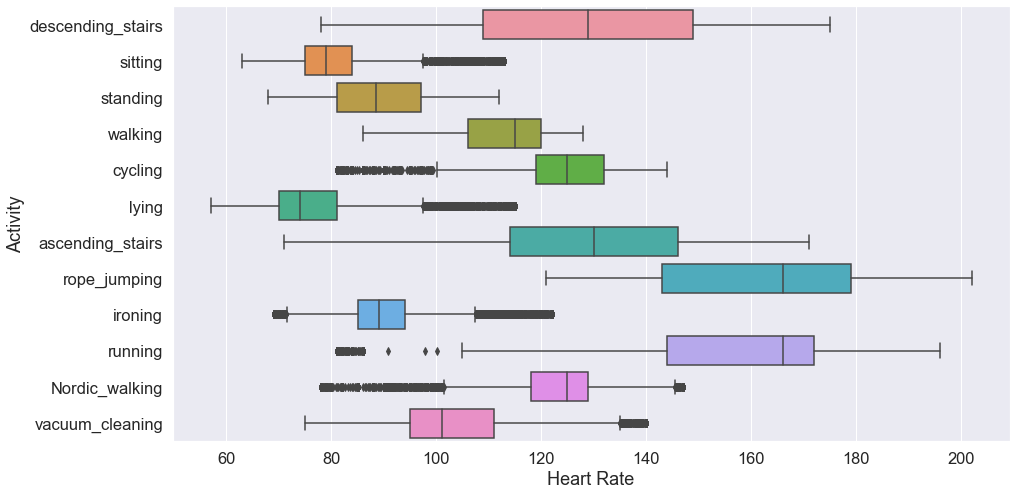

In [161]:
subData = dataTrain[['heartRate',"activityID"]]
subData["activityID"] = subData["activityID"].apply(str).map(activityIDList)
nicePlots('boxplot',subData,xaxis='heartRate',yaxis="activityID",xlabel = "Heart Rate",ylabel = "Activity",title = None)

 <p>From the above boxplots it can be clearly seen that some activities are evidently more intense than other. For example, hear rate distributions for intense activities such as rope jumping, running, descending and ascending stairs are towards the higher end as compared with the other activities which can be labeled as less intense activities. Moreover, these intense activities have a wider distributions which also suggests that different subjects may have performed these activities in a unique manner but on an average the intensity remains towards the higher end of the spectrum. 
On the other hand the activities which require less effort have relatively narrower distributions as effort required is not much so the subject's bodies behave more similarly when at rest while when doing some activity.</p>

<p>Let us try to create a similar plot for body temperatures to identify any trend in temperatures of body parts and activities being performed.</p>

<Figure size 1440x360 with 0 Axes>

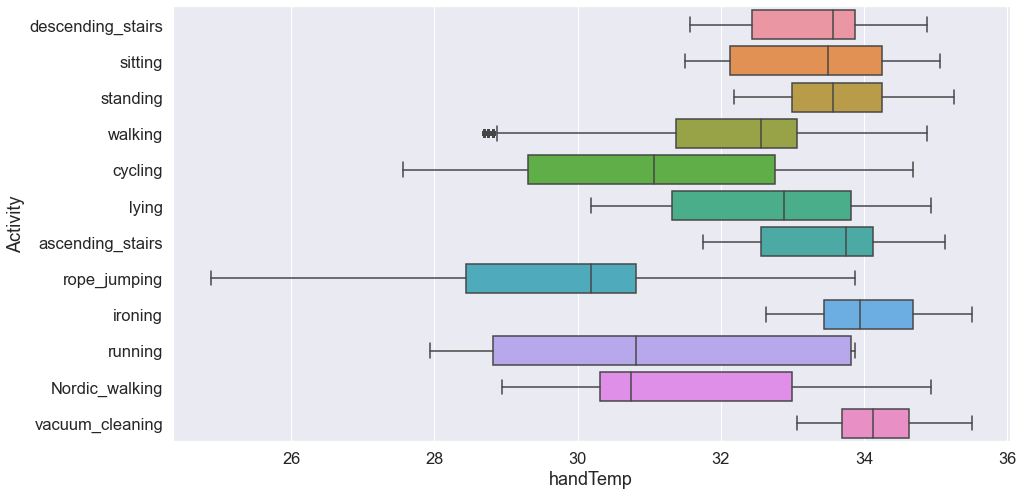

<Figure size 1440x360 with 0 Axes>

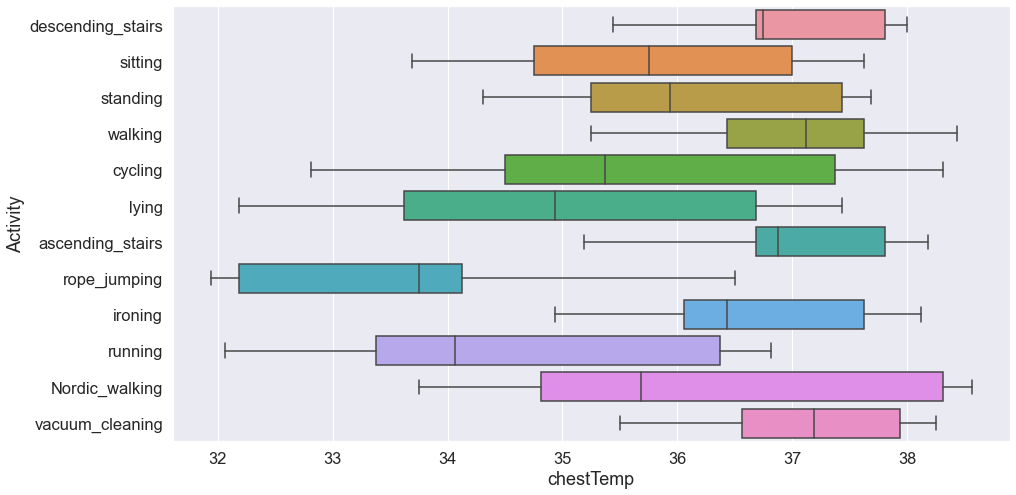

<Figure size 1440x360 with 0 Axes>

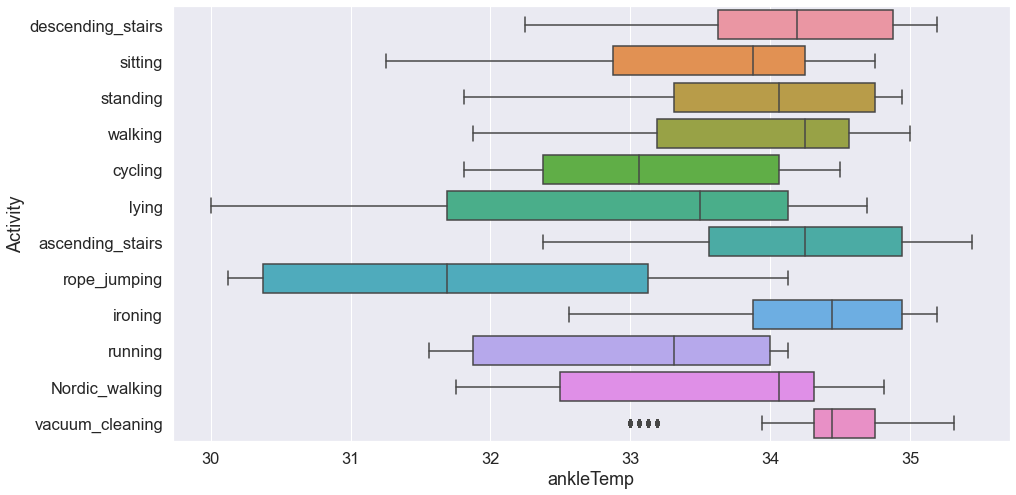

In [163]:
for plotme in ['handTemp','chestTemp','ankleTemp']:
    subData = dataTrain[[plotme,"activityID"]]
    subData["activityID"] = subData["activityID"].apply(str).map(activityIDList)
    nicePlots('boxplot',subData,xaxis=plotme,yaxis="activityID",xlabel = plotme,ylabel = "Activity",title = None)

<p>It seems, from the plots, that the median temperature while rope skipping is lower than other activities. There is no logical resoning for the same however we conduct a hypothesis test to statistically verify the observation. </p>

<module 'matplotlib.pyplot' from 'C:\\Users\\kshit\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

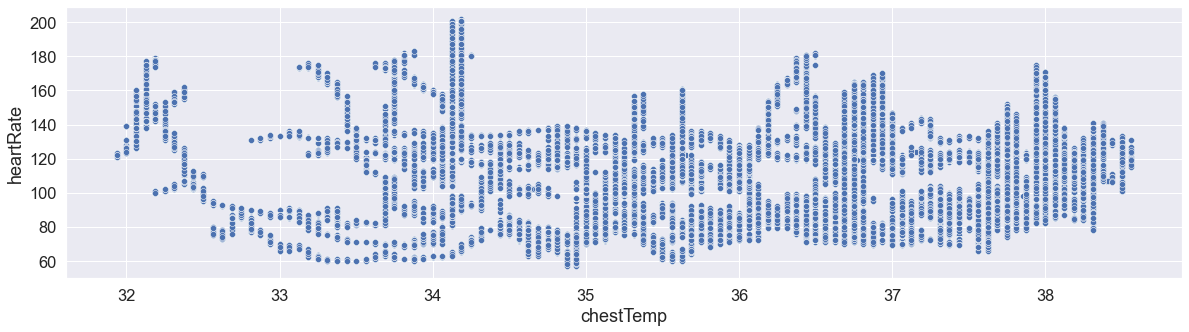

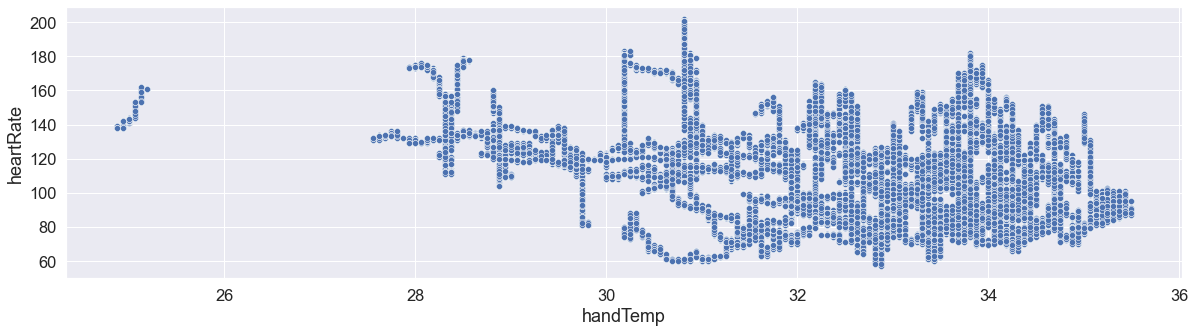

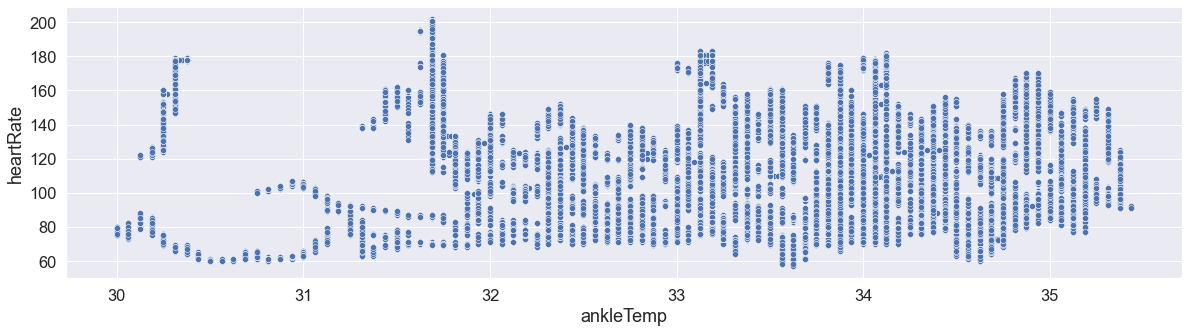

In [148]:
nicePlots('scatter', dataTrain, 'chestTemp','heartRate')
nicePlots('scatter', dataTrain, 'handTemp','heartRate')
nicePlots('scatter', dataTrain, 'ankleTemp','heartRate')

<p>No clear pattern observed in the scatterplot between heartrate and body temperatures.</p>

# 5. Hypothesis Testing
<p>Hypothesis testing is conducted to find statistical evidence for the observations. We will conduct two hypothesis tests to check whether the observations made in previous sections are statistically significant or just random coincidence. Two observations for which hypothesis test will be conducted are mentioned below:</p>
<ol>
    <li>Mean heart rate of more intense activities like rope jumping, running, descending and ascending stairs is higher as compared to that other less intense activities.</li>
    <li>Mean temperature while skipping ropes is lower as compared to other activies</li>
    </ol>

### 5.1 Testing Hypothesis 1

<p>We would like to know if the difference between the mean heart rate of subjects while performing intense activities like rope jumping, running, descending and ascending stairs is significantly different as compared to that other less intense activities.

<ul><li>Null Hypothesis: H0 - There is no difference in the mean heart rates of subjects while performing more intense and less intense activities.</li>
    
<li>Alternative Hypothesis: H1 - There is a significant difference between the mean heart rates of subjects while performing more intense and less intense activities.</li></ul>

The favourable outcome would be if we can reject the null hypothesis with a 95% confidence interval. In other words, we would like to confirm that 95% of the times the means are statistically different.</p>

In [208]:
dataTrain['activityIntense'] = ['intense' if i in [5,12,13,24] else 'not_intense' for i in  dataTrain['activityID']]

In [223]:
# Function to Conduct Hypothesis testing
def hypTest(data, bifurcateBy, testCol, label1, label2):
    hr_means=data.groupby(bifurcateBy)[testCol].mean()
    hr_std=data.groupby(bifurcateBy)[testCol].std()
    hr_count=data.groupby(bifurcateBy)[testCol].count()
    print(hr_means, hr_std, hr_count)
    combinederror=(((hr_std[label1]**2)/hr_count[label1])+((hr_std[label2]**2)/hr_count[label2]))**0.5   
    z=(hr_means[label1]-hr_means[label2])/combinederror
    print(z)
    p_value_from_normal_for_diff = (1-stats.norm.cdf(z))
    print ('\n\nOne Tail intense vs non intense activity difference: ', p_value_from_normal_for_diff)
    return p_value_from_normal_for_diff

In [224]:
hypTest(dataTrain, "activityIntense", "heartRate", "intense", "not_intense")

activityIntense
intense        140.928407
not_intense     99.624325
Name: heartRate, dtype: float64 activityIntense
intense        26.329880
not_intense    20.300822
Name: heartRate, dtype: float64 activityIntense
intense         247711
not_intense    1054013
Name: heartRate, dtype: int64
731.340265658893


One Tail intense vs non intense activity difference:  0.0


0.0

As the p-value is just 0% which below 5% significance level, we can neglect the null hypothesis and accept the alternate hypothesis which states that there is a significant difference between the mean heart rates of subjects while performing more intense and less intense activities.

In [232]:
dataTrain = dataTrain.drop('activityIntense', axis=1)

### 5.2 Testing Hypothesis 2

<p>We would like to know if the difference between the mean chest temperature of subjects while performing rope jumping is significantly different as compared to that other activities.

<ul><li>Null Hypothesis: H0 - There is no significant difference in the mean chest temperature of subjects while performing rope jumping as compared to that of other activities.</li>
    
<li>Alternative Hypothesis: H1 - There is a significant difference in the mean chest temperature of subjects while performing rope jumping as compared to that of other activities.</li></ul>

The favourable outcome would be if we can reject the null hypothesis with a 95% confidence interval. In other words, we would like to confirm that 95% of the times the means are statistically different.</p>

In [226]:
dataTrain['isropejump'] = ['yes' if i == 24 else 'no' for i in  dataTrain['activityID']]

In [228]:
hypTest(dataTrain, "isropejump", "chestTemp", "yes", "no")

isropejump
no     36.246640
yes    33.602023
Name: chestTemp, dtype: float64 isropejump
no     1.435306
yes    1.474523
Name: chestTemp, dtype: float64 isropejump
no     1268653
yes      33071
Name: chestTemp, dtype: int64
-322.20823437357456


One Tail intense vs non intense activity difference:  1.0


1.0

As the p-value is just 100% which higher than 5% significance level, we can not neglect the null hypothesis and therefore there is no statistical evidence that mean temperatures are different while performing rope skipping as compared to other activities.

In [234]:
dataTrain = dataTrain.drop('isropejump', axis=1)

# 6. Model Development

In this section we will try to fit a couple of model to find the bet model for the given data. We will be using the training data to fit the model and subsequently perform some tests to select the best model which shall produce desired results. In order to start the modeling process we need to remove a couple columns which can create issues during the process. These columns are timeStamp and subjectID.

In [230]:
# Importing modeing packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
train_df = train_df.drop(["timestamp", "subject_id"],1)

In [233]:
dataTrain

,timeStamp,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handMagn_1,handMagn_2,handMagn_3,...,chestMagn_3,ankleTemp,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleMagn_1,ankleMagn_2,ankleMagn_3,subjectID,isropejump
0,2038.56,13,158.0,33.2500,-7.35968,2.28006,5.194930,8.805710,-13.23800,-3.18283,...,-10.08810,35.0000,8.67393,-2.906790,-4.231220,-36.96500,19.15340,28.06230,106,no
1,384.34,2,85.0,32.1875,1.88464,8.23650,4.774480,-10.171400,-26.03470,-69.41560,...,-35.34630,32.6250,-1.12358,0.846263,-9.989060,-11.53370,33.69820,72.68790,101,no
2,726.66,3,71.0,33.2500,-9.31532,2.44787,1.046920,30.867400,-16.89900,-5.17380,...,-3.38165,32.5000,9.17009,0.205475,-4.476980,4.24416,-6.37674,13.48630,107,no
3,2549.15,4,95.0,31.5625,-13.43790,4.44816,0.478085,54.820500,-13.48340,-36.86990,...,-17.50200,34.8750,9.86913,-1.061070,-3.342860,-55.83180,32.10370,-3.36399,106,no
4,3016.27,6,116.0,30.6875,-4.69561,3.34432,7.732920,25.373900,-27.42880,-44.46840,...,10.31630,31.8750,19.64920,-3.690840,-4.962770,-38.39830,-18.15970,11.64800,108,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301719,2675.55,7,146.0,32.3125,-12.39240,55.90400,18.948000,-0.959889,-63.81860,-7.55063,...,26.88770,34.1250,13.96340,0.277704,-3.039050,-47.41050,-41.48580,21.67770,101,no
1301720,1077.00,17,92.0,35.3125,-2.03662,9.85849,0.284227,44.638200,-114.65900,22.94990,...,-10.75220,34.5000,9.65815,-0.569270,-2.962180,-38.38520,15.79290,43.23720,105,no
1301721,2875.70,6,126.0,33.0000,-4.30811,4.32849,7.812380,53.048700,-7.80815,-42.28130,...,46.71520,32.3750,2.98744,2.610350,-1.313790,-33.99440,-32.79580,12.67330,107,no
1301722,307.36,1,84.0,31.8750,1.34155,9.54305,1.913880,26.122000,-62.31370,-9.81195,...,39.23550,32.3125,9.78438,-0.014349,-1.266390,-83.14140,-39.19380,-56.97650,101,no


In [ ]:
dataTrain = dataTrain.drop(['timeStamp','subjectID'], axis=1)

In [249]:
dataTest = dataTest[dataTrain.columns]
dataTest.head()

,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handMagn_1,handMagn_2,handMagn_3,chestTemp,...,chestMagn_1,chestMagn_2,chestMagn_3,ankleTemp,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleMagn_1,ankleMagn_2,ankleMagn_3
0,7,129.0,34.7500,-9.52337,12.01650,-2.56780,10.8357,-37.42810,-13.40760,38.5000,...,7.34547,-33.6202,-6.53485,34.3125,10.78650,-0.349856,-2.79761,-36.4920,19.4738,13.73850
1,16,110.0,34.6875,-10.15230,-9.22155,2.18989,53.5705,9.29874,-28.47550,38.2500,...,-30.27050,-11.6429,36.50800,34.6875,9.57283,0.374232,-2.19712,-23.1775,-18.8524,-9.43062
2,2,98.0,34.2500,-1.97168,-8.70099,8.16075,11.7041,18.85380,-30.54840,37.5625,...,4.86426,-25.9225,-3.77573,33.8125,9.15148,0.010087,-3.78135,-19.8775,12.8898,26.71130
3,4,93.0,31.7500,-8.21659,3.66181,1.98298,34.4071,24.73230,-5.82714,36.5000,...,9.01484,-22.1131,29.79060,34.8750,16.13800,9.486570,-7.24157,-31.8945,-17.3215,12.94640
4,4,123.0,31.6875,-11.16700,2.46217,1.01914,34.4899,-19.18560,-24.95060,36.4375,...,12.88610,-21.5281,32.24130,34.5000,11.56320,-4.655060,-6.23599,-35.6133,-13.9738,3.67918


In [250]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,RobustScaler

#apply scaling to all columns except subject and activity 
scaler = RobustScaler()
df_scaled = dataTrain.copy()
df_scaled_test = dataTest.copy()

df_scaled.iloc[:,1:23] = scaler.fit_transform(df_scaled.iloc[:,1:23])
df_scaled_test.iloc[:,1:23] = scaler.fit_transform(df_scaled_test.iloc[:,1:23])

df_scaled.head()

,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handMagn_1,handMagn_2,handMagn_3,chestTemp,...,chestMagn_1,chestMagn_2,chestMagn_3,ankleTemp,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleMagn_1,ankleMagn_2,ankleMagn_3
0,13,1.421053,0.052632,-0.238190,-0.231329,0.327976,-0.409592,0.093330,0.751544,0.111111,...,-0.349002,0.964657,-0.434604,0.625000,-0.462955,-0.662110,-0.655169,-0.123700,0.606580,0.338031
1,2,-0.500000,-0.394737,0.914629,0.872509,0.249676,-0.958908,-0.316160,-1.654626,-1.111111,...,0.555032,-2.087486,-1.275363,-0.958333,-5.710488,0.286934,-2.737872,0.943507,1.086223,1.966081
2,3,-0.868421,0.052632,-0.482070,-0.200231,-0.444501,0.229011,-0.023821,0.679214,-0.222222,...,-0.287104,0.182913,-0.211370,-1.041667,-0.197213,0.124897,-0.744064,1.605614,-0.235325,-0.193736
3,4,-0.236842,-0.657895,-0.996179,0.170460,-0.550434,0.922364,0.085477,-0.472273,-0.027778,...,0.826636,-1.003054,-0.681388,0.541667,0.177192,-0.195378,-0.333835,-0.915433,1.033642,-0.808475
4,6,0.315789,-1.026316,0.094034,-0.034102,0.800621,0.069995,-0.360770,-0.748319,-0.750000,...,-0.598716,-0.525199,0.244588,-1.458333,5.415383,-0.860375,-0.919782,-0.183848,-0.623891,-0.260802


In [251]:
df_scaled_test.head()

,activityID,heartRate,handTemp,handAcc16_1,handAcc16_2,handAcc16_3,handMagn_1,handMagn_2,handMagn_3,chestTemp,...,chestMagn_1,chestMagn_2,chestMagn_3,ankleTemp,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleMagn_1,ankleMagn_2,ankleMagn_3
0,7,0.642178,0.684211,-0.508943,1.575137,-1.116214,-0.350471,-0.685094,0.380955,0.916667,...,0.229381,-0.010580,-0.315736,0.166667,0.669080,-0.013605,-0.137229,-0.105333,0.615495,-0.181495
1,16,0.142178,0.657895,-0.587554,-2.363753,-0.230256,0.886195,0.813675,-0.166635,0.805556,...,-1.651197,1.373936,1.115054,0.416667,0.018413,0.169570,0.079431,0.454721,-0.648512,-1.025795
2,2,-0.173611,0.473684,0.434963,-2.267208,0.881614,-0.325341,1.120155,-0.241967,0.500000,...,0.105335,0.474356,-0.224020,-0.166667,-0.207479,0.077451,-0.492168,0.593530,0.398353,0.291244
3,4,-0.305190,-0.578947,-0.345605,0.025644,-0.268786,0.331641,1.308709,0.656439,0.027778,...,0.312840,0.714339,0.891761,0.541667,3.538102,2.474743,-1.740636,0.088054,-0.598022,-0.210360
4,4,0.484284,-0.605263,-0.714384,-0.196846,-0.448268,0.334037,-0.099964,-0.038535,0.000000,...,0.506380,0.751193,0.973224,0.291667,1.085481,-1.102704,-1.377817,-0.068372,-0.487614,-0.548064


In [252]:
X_train = df_scaled.drop('activityID', axis=1).values
y_train = df_scaled['activityID'].values

# Test Dataset
X_test = df_scaled.drop('activityID', axis=1).values
y_test = df_scaled['activityID'].values

## 6.1 Pricipal component Analysis

Principla component analysis is a dimentionality reduction tool which is used when there are high number of dimensions/features per observation. It help in increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data.
Usually 90-98% of the variance will explain our data really well. So by plotting the variance ratio aginst the number of components we can find how many of those we could use. As we see from the graph below 13 components fall around to 94% of the variance. 

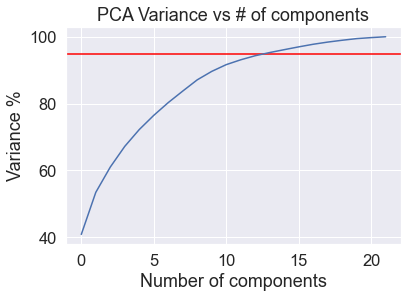

In [259]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance vs # of components")
plt.ylabel("Variance %")
plt.xlabel("Number of components")
l = plt.axhline(95, color="red")

plt.plot(var1)

In [ ]:
# Taking 15 components
pca = PCA(n_components=15)
X_train=pca.fit_transform(X_train)
X_test=pca.fit_transform(X_test)

## 6.2 Model Selection

In the following section we will fit two model in our data and subsequently test their performance against the test dataset to finally recommend a suitable model for our purpose.

The two models which we are going to use are <b>Logistic Regression and Random forest</b>:

<ol><li>Logistic Regression algorithm is a simple algorithm that can be used for binary/multivariate classification tasks. The result of it is a probability that a data point is a part of a particular class.</li>

<li>Random Forest algorithm can be used for both classification and regression which makes it a very versatile modeling algorithm. As the name suggests, Random Forest is a forest of decision trees, which are randomly populating the forest. The algorithms creates and combines decision trees together, the more trees in the forest, the better the accuracy of its predictions. Random Forest algorithms are good because of the high accuracy they provide as well as beacuse of their flexibility i.e. it can work for both classification and regression modelling. In addition, Random Forest performs well with high dimensionality datasets which is the case with our dataset.</li>

In [264]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
   
    print("Accuracy: ",acc)
    print("Error: ",err)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)

In [265]:
# Running Logistic regression model and printing out test results
log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train )
y_pred_lr = log_reg.predict(X_test)
get_metrics(y_test, y_pred_lr)

Accuracy:  0.8114485098223586
Error:  0.1885514901776414
Precision 0.7840655661660696
Recall 0.7713822228520518
F1 0.7759365358747266


It can be seen that the accuracy and precision of the logistic model is quite high therefore it reduces both type 1 and type 2 errors, which is a good sign for a model.

In [266]:
# Running Random forest model and printing out test results
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs =4)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
get_metrics(y_test,y_pred_rf)

Accuracy:  1.0
Error:  0.0
Precision 1.0
Recall 1.0
F1 1.0


## 6.3 Cross validation
Even though the above models seem to perform good, the metrics used for analysis does not provide a full picture as the model were built on a specific part of the parent dataset. By using cross validation, we can create k number of different samples from the dataset and subsequently testing the model on each of the sample. By performing this exercise we will get k different sets of metrics. The mean value of these metrics can show a better picture of the model's performance.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

classifiers = [LogisticRegression(),
               RandomForestClassifier(n_jobs = 4)]

score_lst = []
for cls in classifiers:
    # Cross validating the accurancy
    accs  = accuracy_score(y_train, cross_val_predict(cls,X_train,y_train,cv = 10))
    # calcuating the error
    scores = cross_val_score(cls,X_train,y_train,scoring = "neg_mean_squared_error",cv= 10)
    score = np.sqrt(-scores)
    f1 = cross_val_score(cls,X_test, y_test,scoring = "f1_macro", cv =10)
    score_lst.append([cls.__class__.__name__,accs,score.mean(), f1.mean()])

df_scores=pd.DataFrame(columns = ["Classifier","Accuracy","MSE","F1"],data =  score_lst)
display(df_scores)

# 7. Conclusion
We performed the necessary steps for model development beginning from data preparation to data cleaning and subsequently exploring hidden trends within the data. Hypothesis tests conducted gave more clarity about the data and helped us to form a platform for final model development.

It can be concluded from the above results that randomforest classifier is an appropriate model for predicting the activity type given the required sensory data. High accuracy and precision ensure that the model minimises the type 1 and type 2 errors. Therefore, it is recommended to use the model developed by using random forest modeling algorithm.

# 8. References

Archive.ics.uci.edu. (2012) PAMAP2 Physical Activity Monitoring Data Set http://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring [Accessed 15 Dec. 2018].

Donges, N. (2018). The Random Forest Algorithm – Towards Data Science. [online] Towards Data Science. Available at: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd [Accessed 3 Jan. 2019].

https://en.wikipedia.org/wiki/Principal_component_analysis

https://www.statology.org/z-test-python/

PAMAP2_Dataset: Physical Activity Monitoring. (n.d.). [ebook] Available at: http://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf [Accessed 15 Dec. 2018].

Scikit-learn.org. (n.d.). Robust Scaling on Toy Data — scikit-learn 0.18.2 documentation. https://scikit-learn.org/0.18/auto_examples/preprocessing/plot_robust_scaling.html